# Day 24

## Part 1

- map the valley, dodge the blizzards of snow!
- the blizzards move forwards in a direction one step at a time each minute
    - if a blizzard hits a wall ~~it bounces off next turn~~ it disappears and another one forms next to the wall opposite, moving in the same direction.
    - 2 blizzards can occupy the same spot and will continue as if nothing happened the next turn.
- the expedition begins in the only non wall space in the top row
- the goal is the only non wall space in the bottom row
- each minute the expedition can move to any cardinally adjacent square or not move
`What is the fewest number of minutes required to avoid the blizzards and reach the goal?`

In [201]:
from __future__ import annotations

from copy import deepcopy
from dataclasses import dataclass
from itertools import count
from matplotlib import pyplot as plt
from utils import parse_from_file, ParseConfig

parser = ParseConfig('\n', ParseConfig('', str))

valley = parse_from_file('day_24.txt', parser)

print(valley[1][:10])

['#', '<', '>', 'v', '^', '<', 'v', 'v', '<', 'v']


In [202]:
# to ensure we keep track of overlapping blizzards let's extract all their
# positions
@dataclass
class Blizzard:
    x: int
    y: int
    step_x: int
    step_y: int

    @property
    def position(self) -> tuple[int]:
        return (self.x, self.y)
    
    @position.setter
    def position(self, new_position: tuple[int]) -> None:
        self.x, self.y = new_position
    
    @property
    def direction(self) -> tuple[int]:
        return (self.step_x, self.step_y)
    
    @property
    def next_position(self) -> tuple[int]:
        """returns the next position but doesn't go there yet"""
        return (self.x + self.step_x, self.y + self.step_y)

    @property
    def step(self) -> Blizzard:
        """return a copy stepped forward"""
        return Blizzard(
            self.x + self.step_x, self.y + self.step_y, *self.direction)
    
    @property
    def rebound(self) -> Blizzard:
        """return a copy rebounded"""
        return Blizzard(
            self.x - self.step_x, self.y - self.step_y,
            -self.step_x, -self.step_y
        )

directions = {'>': (1, 0), 'v': (0, 1), '<': (-1, 0), '^': (0, -1)}

starting_blizzards = []
for y, row in enumerate(valley):
    for x, material in enumerate(row):
        if material in ['.', '#']:
            continue
        starting_blizzards.append(Blizzard(x, y, *directions[material]))

print(starting_blizzards[:5])

[Blizzard(x=1, y=1, step_x=-1, step_y=0), Blizzard(x=2, y=1, step_x=1, step_y=0), Blizzard(x=3, y=1, step_x=0, step_y=1), Blizzard(x=4, y=1, step_x=0, step_y=-1), Blizzard(x=5, y=1, step_x=-1, step_y=0)]


In [203]:
# movement of the expedition and blizzards and plotting needs an empty base
empty_valley = []
for row in valley:
    empty_valley.append([])
    for material in row:
        if material in ['#', '.']:
            empty_valley[-1].append(material)
        else:
            empty_valley[-1].append('.')

print(empty_valley[1][:10])

['#', '.', '.', '.', '.', '.', '.', '.', '.', '.']


In [204]:
def get_next_blizzards(
    blizzards: list[Blizzard], empty_valley: list[list[str]]
) -> tuple[list[Blizzard], set]:
    """
    returns a new list of Blizzards stepped forward accounting for walls and
    a set of all positions that are occupied for easy lookup
    """
    new_blizzards = []
    for blizzard in blizzards:
        x, y = blizzard.next_position
        if empty_valley[y][x] == '#':
            while empty_valley[y][x] == '#':
                if blizzard.step_x == 0:
                    y = (y + blizzard.step_y) % len(empty_valley)
                else:
                    x = (x + blizzard.step_x) % len(empty_valley[0])
            new_blizzards.append(Blizzard(x, y, *blizzard.direction))
        else:
            new_blizzards.append(blizzard.step)
    obstacle_set = set([blizzard.position for blizzard in blizzards])
    return new_blizzards, obstacle_set

In [205]:
for x, material in enumerate(empty_valley[0]):
    if material == '.':
        start_position = (x, 0)
        break

for x, material in enumerate(empty_valley[-1]):
    if material == '.':
        end_position = (x, len(empty_valley) - 1)

print(f'start: {start_position}, end: {end_position}')

start: (1, 0), end: (120, 26)


In [206]:
blizzards = [starting_blizzards]
layers = [[start_position]]
for time_elapsed in count(start=0):
    # look at each location in the current layer and determine all possible
    # next steps (or not moving)
    next_blizzards, obstacle_set = \
        get_next_blizzards(blizzards[-1], empty_valley)
    new_layer = []
    for position in layers[-1]:
        for offset in ((0, 0), (1, 0), (0, 1), (-1, 0), (0, -1)):
            x, y = [val + off for val, off in zip(position, offset)]
            # check if we've already considered this position
            if (x, y) in new_layer:
                continue
            # check if it's a wall
            if empty_valley[y][x] == '#':
                continue
            # check if there's a blizzard in the way next
            if (x, y) in obstacle_set:
                continue
            # if none of that was true we can go there next so add it
            new_layer.append((x, y))

    # add the new net to the existing one
    blizzards.append(next_blizzards)
    layers.append(new_layer)
    # now check if we reached the end
    if end_position in layers[-1]:
        break

Text(0.5, 1.0, 'Endfull possibilities')

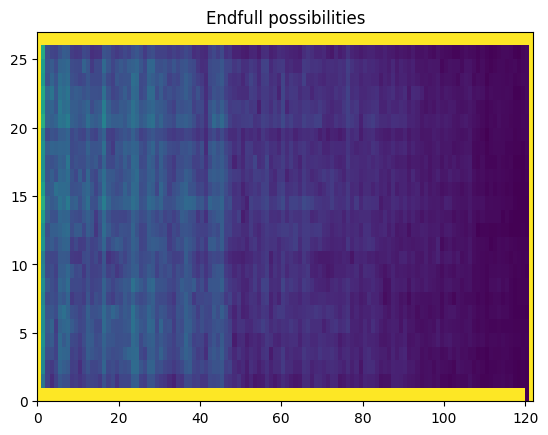

In [208]:
def plot_layers(layers: list[list[tuple[int]]]) -> list[list[int]]:
    """
    creates a plot with the layers produced
    """
    ground = 0
    wall = len(layers)
    grid = []
    for row in empty_valley:
        grid.append([])
        for material in row:
            match material:
                case '#':
                    grid[-1].append(wall)
                case '.':
                    grid[-1].append(ground)
    
    for layer in layers:
        for x, y in layer:
            grid[y][x] += 1
    
    return list(reversed(grid))

fig, ax = plt.subplots()
ax.pcolormesh(plot_layers(layers))
ax.set_title(f'Endfull possibilities')

In [207]:
print(f'the shortest path to the end takes: {len(layers) - 2}!')

the shortest path to the end takes: 295!


In [ ]:
# Turns out I had the blizzard wall interation all wrong for part 1 but still
# inexplicably managed to get the right answer

## Part 2

- there and back for snacks then back again again - an elf's tail

In [209]:
# let's wrap this up in a func so we can do it again and again
def get_layers(
    start_pos: tuple[int], end_pos: tuple[int],
    initial_blizzards: list[Blizzard]
) -> list[tuple[int]]:
    """
    returns the layers from navigating from start to end
    """
    blizzards = [initial_blizzards]
    layers = [[start_pos]]
    for time_elapsed in count(start=0):
        # look at each location in the current layer and determine all possible
        # next steps (or not moving)
        next_blizzards, obstacle_set = \
            get_next_blizzards(blizzards[-1], empty_valley)
        new_layer = []
        for position in layers[-1]:
            for offset in ((0, 0), (1, 0), (0, 1), (-1, 0), (0, -1)):
                x, y = [val + off for val, off in zip(position, offset)]
                y = min(y, len(empty_valley) - 1)
                # check if we've already considered this position
                if (x, y) in new_layer:
                    continue
                # check if it's a wall
                if empty_valley[y][x] == '#':
                    continue
                # check if there's a blizzard in the way next
                if (x, y) in obstacle_set:
                    continue
                # if none of that was true we can go there next so add it
                new_layer.append((x, y))

        # add the new net to the existing one
        blizzards.append(next_blizzards)
        layers.append(new_layer)
        # now check if we reached the end
        if end_pos in layers[-1]:
            break
    return layers, blizzards

In [210]:
# there 
trip_layers = [layers]
trip_blizzards = [blizzards]
# back again
l, b = get_layers(end_position, start_position, trip_blizzards[-1][-1])
trip_layers.append(l)
trip_blizzards.append(b)
# there again again
l, b = get_layers(start_position, end_position, trip_blizzards[-1][-1])
trip_layers.append(l)
trip_blizzards.append(b)

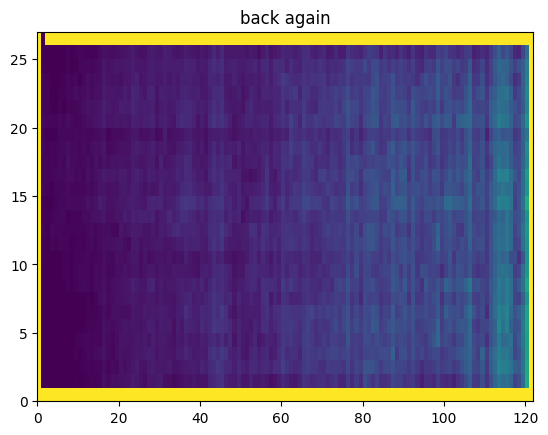

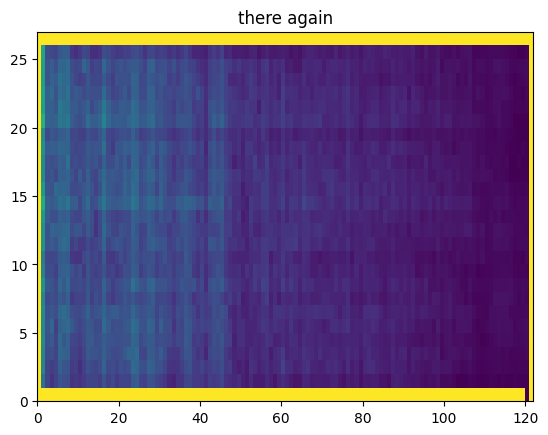

In [211]:
for layers, title in zip(trip_layers[1:], ('back again', 'there again')):
    fig, ax = plt.subplots()
    ax.pcolormesh(plot_layers(layers))
    ax.set_title(title)

In [212]:
total_length = sum([len(layer_set) - 1 for layer_set in trip_layers]) - 1

print(f'the there-back-there shortest trip takes: {total_length}')

the there-back-there shortest trip takes: 851
